In [33]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import regularizers
import numpy as np
import matplotlib.pyplot as plt

## In this file, we create a neural network with one hidden layer and apply it to the mnist dataset in order to address the classification problem.

# loading mnist and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [34]:
print(x_train.shape, y_train.shape, x_test.shape)
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# network parameters
batch_size = 128
num_classes = 10
epochs = 20

# dimensions for the NN:
# input dimension
Q = x_train.shape[1]
# hidden layer dimension
K = 100
# output dimension : classification
D = num_classes

# dropout rate
p = 0.5
N = x_train.shape[0]
# l2 regularization
#prior length scale
l = 1e-2
# precision parameter, un peu au pif pour l'instant
tau = 1e-1

lambd = p*l**2/(2*N)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


(60000, 28, 28) (60000,) (10000, 28, 28)
60000 train samples
10000 test samples


In [35]:
# create a sequential model
model = Sequential()
model.add(Dense(K, input_shape = (Q, ), activation = 'relu', use_bias= True, kernel_regularizer = regularizers.l2(lambd),
               bias_regularizer = regularizers.l2(lambd)))
model.add(Dropout(p))
# softmax layer
model.add(Dense(num_classes, use_bias = False, activation = None, kernel_regularizer = regularizers.l2(lambd)))
model.add(Dropout(p))
model.add(Activation('softmax'))

In [36]:
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 79,500
Trainable params: 79,500
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))

## Obtaining model uncertainty

In [47]:
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def softmax(x):
    norm = np.sum([np.exp(e) for e in x])
    return np.array([np.exp(e)/norm for e in x])

def softmax_in_out(x, model, nb_cl, T = 100) :
    W1, b, W2 = model.get_weights()
    S_in = np.zeros((T, nb_cl))
    S_out = np.zeros((T, nb_cl))
    
    for i in range(T):
        z1 = np.diag(np.random.rand(W1.shape[0]) > 0.5)
        z2 = np.diag(np.random.rand(W2.shape[0]) > 0.5)
        pred = np.dot(sigmoid(np.dot(x, np.dot(z1, W1))), np.dot(z2, W2))
        S_in[i] = pred
        S_out[i] = softmax(pred)
    return S_in, S_out

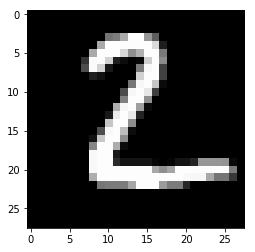

In [48]:
# launch on an example and plot the example
x_ex = x_test[1]
S_in, S_out = softmax_in_out(x_ex, model, nb_cl = num_classes)
x_pl = x_ex.reshape((28,28))
plt.imshow(x_pl, cmap = "gray")
plt.show()

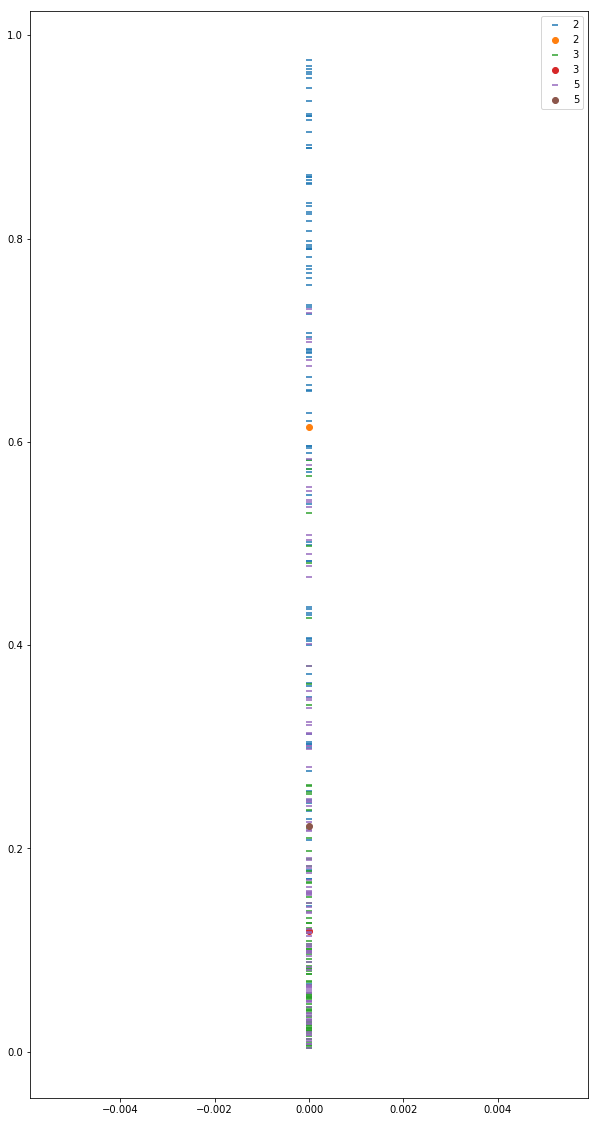

In [84]:
# graphical functions to display the distribution of the predictions
"""
input:  A sample of prediction of size Txnum_classes for an image
        the classes for which displaying the probabilities
output: The plot of the distributions of the predicted probabilities for the desired classes
"""

def plot_pred(S, classes):
    colors = 
    plt.figure(figsize= (10, 20))
    for c in classes:
        plt.scatter(y = S[:,c], x = np.zeros(S.shape[0]), label = c, marker= '_')
        plt.scatter(y = np.mean(S[:,c]), x = 0, label = c)
    plot = plt.legend()
    return plot

plot_pred(S_out, [2,3,5])
plt.show()

In [57]:
# return the different predicted classes
np.unique([np.argmax(e) for e in S_out], return_counts= True)

(array([2, 3, 5]), array([76,  6, 18]))

In [12]:
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.119989572383
Test accuracy: 0.9701


In [13]:
# select ones 
(y_test[1] == 1)

array([False, False,  True, False, False, False, False, False, False, False], dtype=bool)